In [ ]:
import os

import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [36]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
models_dir = os.path.join(project_root,"models")

In [3]:
plt.style.use("default")
plt.rcParams["figure.figsize"]=(8,5)

In [4]:
DATA_PATH=os.path.join("..","data","raw","creditcard.csv")

df=pd.read_csv(DATA_PATH)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df["Class"].value_counts(), df["Class"].value_counts(normalize=True)

(Class
 0    284315
 1       492
 Name: count, dtype: int64,
 Class
 0    0.998273
 1    0.001727
 Name: proportion, dtype: float64)

In [6]:
fraud_df=df[df["Class"]==1]
non_fraud_df=df[df["Class"]==0]

len(fraud_df), len(non_fraud_df)

(492, 284315)

In [8]:
non_fraud_sampled = non_fraud_df.sample(n=20000, random_state=42)

len(non_fraud_sampled)

20000

In [9]:
sampled_df = pd.concat([non_fraud_sampled, fraud_df], axis=0)

sampled_df = sampled_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

sampled_df.shape, sampled_df["Class"].value_counts()

((20492, 31),
 Class
 0    20000
 1      492
 Name: count, dtype: int64)

In [11]:
PROCESSED_PATH = os.path.join("..","data","processed","creditcard_sampled.csv")

os.makedirs(os.path.dirname(PROCESSED_PATH), exist_ok=True)

sampled_df.to_csv(PROCESSED_PATH, index=False)

PROCESSED_PATH

'..\\data\\processed\\creditcard_sampled.csv'

In [12]:
X = sampled_df.drop(columns=["Class"])
y = sampled_df["Class"]
X.shape , y.shape

((20492, 30), (20492,))

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape

(20492, 30)

In [18]:
col_means = X_scaled.mean(axis=0)
col_stds = X_scaled.std(axis=0)

print("approx mean (first 10 cols): ", np.round(col_means[:10],4))
print("approx std (first 10 cols): ", np.round(col_stds[:10],4))

print("mean of means: ",np.round(col_means.mean(),4))
print("mean of stds: ",np.round(col_stds.mean(),4))

approx mean (first 10 cols):  [-0. -0.  0. -0. -0. -0. -0. -0. -0. -0.]
approx std (first 10 cols):  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
mean of means:  -0.0
mean of stds:  1.0


In [19]:
scaled_df=pd.DataFrame(X_scaled,columns=X.columns)

scaled_df["Class"] = y.values

scaled_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.811556,0.757103,-0.360565,-0.865227,0.386771,-0.008512,-0.987970,0.381996,-0.287599,0.541694,...,0.362037,0.828906,-0.340566,-0.111714,0.279030,-0.259357,-0.111614,0.016832,0.675880,0
1,-0.669158,0.540631,0.097158,0.281305,0.613623,-0.034410,-0.251111,0.172915,-0.104089,-0.088977,...,0.001996,0.097660,-0.065961,0.184595,0.952062,-0.870380,0.078490,0.091786,-0.192788,0
2,-0.929712,-0.662161,-0.189280,0.960706,-0.732226,-0.943955,0.613140,0.341616,0.537304,0.218769,...,0.059130,-0.419250,0.777921,0.076827,0.150405,2.344492,-0.571821,-0.034629,0.838643,0
3,-0.702437,0.332287,-0.528414,0.020784,0.475031,-0.401547,-0.505971,0.354923,-0.131436,-0.002314,...,0.177656,-0.128709,-0.561635,0.990719,0.907594,1.013509,-0.272214,0.127199,0.980856,0
4,1.340866,-0.092126,0.621822,-0.640578,0.406873,1.061004,-0.432776,0.612016,0.080997,-0.784382,...,0.314524,1.128806,-0.141900,0.090422,-1.175267,-1.051073,0.909277,0.651057,-0.360073,0


In [20]:
SCALED_PATH = os.path.join("..","data","processed", "creditcard_sample_scaled.csv")
scaled_df.to_csv(SCALED_PATH, index=False)

SCALED_PATH

'..\\data\\processed\\creditcard_sample_scaled.csv'

In [38]:
os.makedirs(models_dir,exist_ok=True)
scaler_path = os.path.join(models_dir,"standard_scalar.joblib")
joblib.dump(scaler,scaler_path)
scaler_path

'u:\\ML\\ml2-unsupervised-creditcard-fraud\\models\\standard_scalar.joblib'

In [24]:
pca_2d = PCA(n_components=2, random_state=42)

x_pca_2d = pca_2d.fit_transform(X_scaled)

x_pca_2d.shape

(20492, 2)

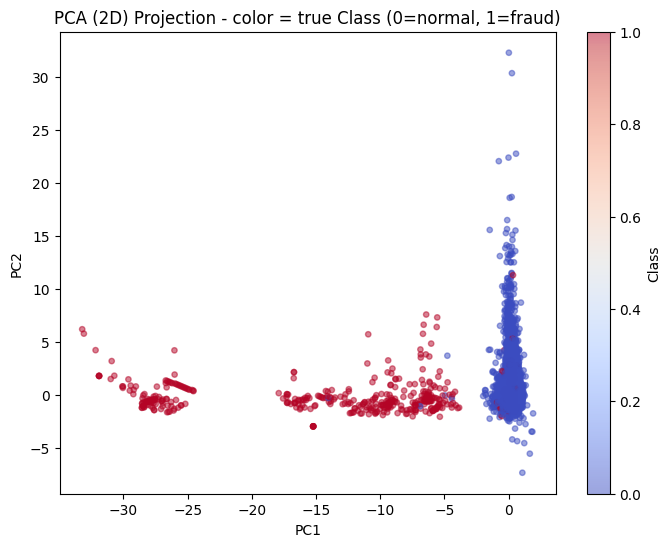

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca_2d[:,0],x_pca_2d[:,1],c=y,alpha=0.5,s=15,cmap="coolwarm")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (2D) Projection - color = true Class (0=normal, 1=fraud)")
plt.colorbar(label="Class")
plt.show()

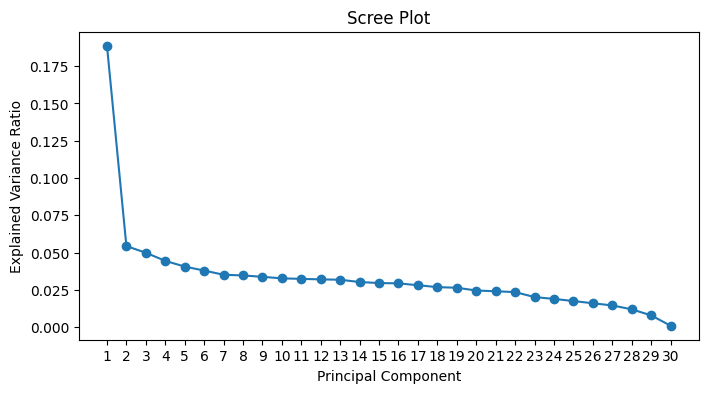

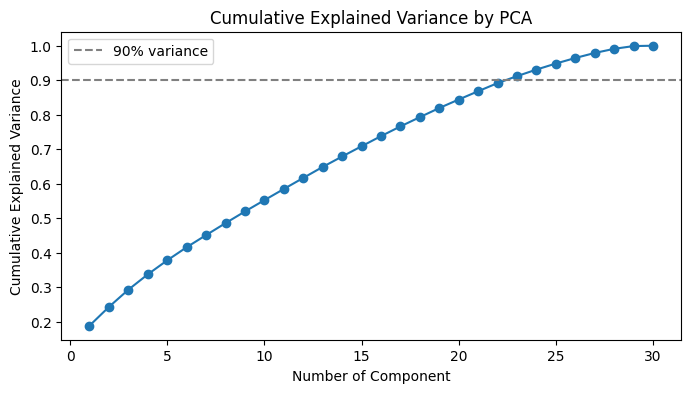

PCA1: 0.1887, cumulative: 0.1887
PCA2: 0.0544, cumulative: 0.2431
PCA3: 0.0499, cumulative: 0.2930
PCA4: 0.0445, cumulative: 0.3375
PCA5: 0.0406, cumulative: 0.3781
PCA6: 0.0380, cumulative: 0.4161
PCA7: 0.0352, cumulative: 0.4512
PCA8: 0.0347, cumulative: 0.4859
PCA9: 0.0338, cumulative: 0.5197
PCA10: 0.0328, cumulative: 0.5525


In [29]:
pca_full = PCA(n_components=min(X_scaled.shape[1], 30), random_state=42)
pca_full.fit(X_scaled)

explained = pca_full.explained_variance_ratio_
cumulative = explained.cumsum()

plt.figure(figsize=(8,4))
plt.plot(range(1,len(explained)+1), explained, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.xticks(range(1,len(explained)+1))
plt.show()

plt.figure(figsize=(8,4))
plt.plot(range(1,len(explained)+1), cumulative, marker='o')
plt.xlabel("Number of Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by PCA")
plt.axhline(0.9, color='gray', linestyle='--', label='90% variance')
plt.legend()
plt.show()

for i, (e,c) in enumerate(zip(explained[:10],cumulative[:10]),start=1):
    print(f"PCA{i}: {e:.4f}, cumulative: {c:.4f}")


In [33]:
pca_df = pd.DataFrame(x_pca_2d, columns=["PC1", "PC2"])
pca_df["Class"]=y.values

In [34]:
PCA_SAVE_PATH = os.path.join(project_root,"data","processed","creditcard_pca2d.csv")
os.makedirs(os.path.dirname(PCA_SAVE_PATH), exist_ok=True)
pca_df.to_csv(PCA_SAVE_PATH, index=False)

PCA_SAVE_PATH

'u:\\ML\\ml2-unsupervised-creditcard-fraud\\data\\processed\\creditcard_pca2d.csv'

In [35]:
n_80 = int(np.argmax(cumulative >= 0.80)+1)
n_90 = int(np.argmax(cumulative >= 0.90)+1)
n_80, n_90

(19, 23)

In [40]:
N=max(10,n_80)

pca_n = PCA(n_components=N, random_state=42)
X_pca_n = pca_n.fit_transform(X_scaled)

os.makedirs(models_dir,exist_ok=True)
joblib.dump(pca_n, os.path.join(models_dir, f"pca_top{N}.joblib"))

['u:\\ML\\ml2-unsupervised-creditcard-fraud\\models\\pca_top19.joblib']

In [43]:
pca_n_df = pd.DataFrame(X_pca_n, columns=[f"PC{i+1}" for i in range(N)])
pca_n_df["Class"] = y.values
PCA_N_SAVE = os.path.join(project_root,"data","processed",f"creditcard_pca_{N}components.csv")
os.makedirs(os.path.dirname(PCA_N_SAVE,), exist_ok=True)
pca_n_df.to_csv(PCA_N_SAVE,index=False)

PCA_N_SAVE

'u:\\ML\\ml2-unsupervised-creditcard-fraud\\data\\processed\\creditcard_pca_19components.csv'

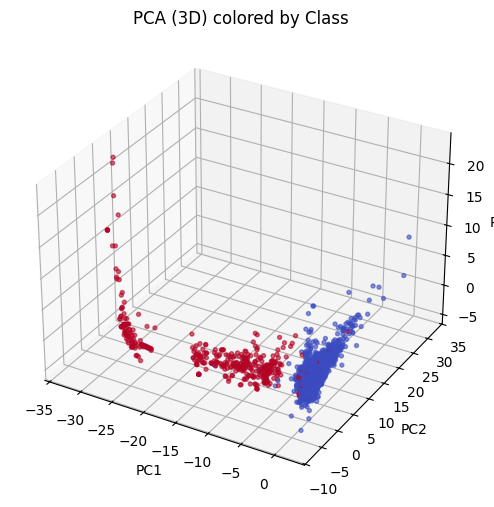

In [48]:
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_pca_3d[:,0], X_pca_3d[:,1],X_pca_3d[:,2], c=y, s=8, alpha=0.6, cmap="coolwarm")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("PCA (3D) colored by Class")
plt.show()